# User behavior as a predictor for input accuracy
Johann Miller, University of Maryland Makeability Lab

### Introduction
[Project Sidewalk](http://sidewalk.umiacs.umd.edu) is an online platform for identifying accessibility problems in sidewalks. Users navigate streets using Google Street View, and place labels on issues such as crosswalks without curbramps, uneven pavement, and obstacles blocking the path. In order to ensure some level of accuracy in the data, Project Sidewalk can use a couple tools. Each user has to complete a tutorial before they can begin to report problems. Another option is ground truth seeding, where users place labels in a region that already has established answers. If the user enters data that doesn't match the ground truth, then all of the data they entered can be flagged.

Here, we will investigate another possible option: using the user's interactions with the tool to predict their accuracy. Consider a user who is inactive for long periods, and barely uses any of the tool's features. This user probably gives worse input than a user who works consistently and employs all of the tool's features. Aspects of interaction include mouse movement, keypresses, and others that we can collect while users place labels. If accurate labels correspond to a certain type of usage, then these features could predict the accuracy of a user even in non ground truth regions.

To see if this is possible, we'll use data from ground truth regions to train and test a classifier.

### Setup python notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import multiclass
from sklearn import svm


In [2]:
%%html
<style>
img {margin-left: 0!important} /* left align images */
</style>

### Collecting user events
Project Sidewalk has logs for variety of user events. The events range from low-level (mouse movements, clicks, etc.) to high-level (zoom in/out, changing label mode, etc.). If we query the interaction table, we can see all the event types.

In [3]:
event_types = pd.read_csv('data/interim/event-types.csv')
print('Num of event types:', len(event_types))
event_types.head()

Num of event types: 109


,event_type
0,Click_LabelDelete
1,Click_ModeSwitch_CurbRamp
2,Click_ModeSwitch_NoCurbRamp
3,Click_ModeSwitch_NoSidewalk
4,Click_ModeSwitch_Obstacle


For each user session, we have a collection of the events that were triggered. In order to compare two sessions, we can look at the total number of each type of event. We also look at the mean and standard deviation of the number of events per Google Street View panorama. This way, a user session in a large region can be compared fairly to a session in a smaller region since the former will have more panoramas.

We can load in these event counts from `features.csv`. This file was created by **TODO**.

In [4]:
features = pd.read_csv('data/interim/feature-names.csv')
print('Num of features:', len(features))
features.head()

Num of features: 327


,feature
0,Click_LabelDelete_per_pan_mean
1,Click_LabelDelete_per_pan_std
2,Click_LabelDelete_total
3,Click_ModeSwitch_CurbRamp_per_pan_mean
4,Click_ModeSwitch_CurbRamp_per_pan_std


### Grading user accuracy
We need to rate each user session on its accuracy compared to the ground truth. We do so by counting the number of true positives, false positives, true negatives, and false negatives from the session. These are defined as follows:

#### True positive
The user placed a correct label. Here, the green icon is a label for a curb ramp. The user placed it correctly, so this is a true positive.

![true positive](images/true-pos.png)

#### False positive
The user placed an incorrect label. Here, the user placed a green icon to identify a curb ramp, but none are present.

![false positive](images/false-pos.png)

#### True negative
There was nothing to label, and the user didn't label anything. The amount of empty space necessary to be considered a true negative is the `granularity`. The scoring was done with three values: 5 meter, 10 meter, and street.

![true negative](images/true-neg.png)

#### False negative
There was something to label, but the user missed it. Here, there is a curb ramp with no label.

![false negative](images/false-neg.png)

In [5]:
raw_scores = pd.read_csv('data/interim/processing/scores.csv')
raw_scores.head()

,condition_id,worker_id,type,granularity,label.type,true_pos,false_pos,true_neg,false_neg
0,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,5_meter,Problem,27,26,186,17
1,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,10_meter,Problem,27,15,76,12
2,70,01232fef-5a19-4435-8be6-c0da3b38cabd,volunteer,street,Problem,17,0,0,0
3,72,9501513f-3822-4921-861e-8f1440dee102,volunteer,5_meter,Problem,22,58,161,7
4,72,9501513f-3822-4921-861e-8f1440dee102,volunteer,10_meter,Problem,21,44,59,3


### Composite scores
We can combine the counts of true positives, true negatives, etc. into metrics that tell us about the accuracy of the user.

$\text{accuracy} = \frac{\text{true positives + true negatives}}{\text{true positives + false positives + true negatives + false negatives}}$

$\text{positive predictive value (ppv)} = \frac{\text{true positives}}{\text{true positives + false positives}}$

$\text{negative predictive value (npv)} = \frac{\text{true negatives}}{\text{true negatives + false negatives}}$

$\text{recall} = \frac{\text{true positives}}{\text{true positives + false negatives}}$

$\text{specificity} = \frac{\text{true positives}}{\text{true positives + true negatives}}$

In [6]:
scores = pd.read_csv('data/interim/processing/scores-comb-acc.csv')
scores[scores.columns[4:]].head()

,true_pos,false_pos,true_neg,false_neg,accuracy,ppv,npv,recall,specificity
0,116,86,1564,54,0.923077,0.574257,0.966625,0.682353,0.947879
1,112,136,3262,74,0.941406,0.451613,0.977818,0.602151,0.959976
2,76,18,140,4,0.907563,0.808511,0.972222,0.950000,0.886076
3,120,110,1564,99,0.889593,0.521739,0.940469,0.547945,0.934289
4,95,151,3264,132,0.922295,0.386179,0.961131,0.418502,0.955783


### Data exploration
Now that we've collected features for user interaction and labeled them based on accuracy, we can begin to examine it.

In [7]:
from sklearn import preprocessing

data = pd.read_csv('data/final/interaction-comb.csv')

label_cols = data.columns[8:13].tolist()
feature_cols = data.columns[13:].tolist()

#### Shape of the data

In [8]:
print('Num of users (samples):', len(data[['condition_id', 'worker_id']].drop_duplicates()))
print('  Num of turkers:', len(data[data.type == 'turker'][['condition_id', 'worker_id']].drop_duplicates()))
print('  Num of volunteers:', len(data[data.type == 'volunteer'][['condition_id', 'worker_id']].drop_duplicates()))
print('Num of features:', len(feature_cols))

Num of users (samples): 308
  Num of turkers: 264
  Num of volunteers: 44
Num of features: 291


We almost have more features than samples, meaning our data may be sparse. We can look into the complexity of the data by finding the correlations of the features.

#### Feature correlation

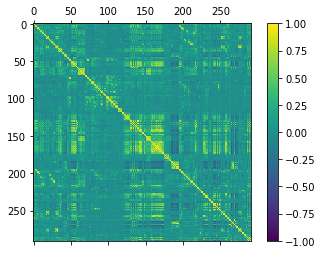

Average absolute feature correlation: 0.116891488326 



In [9]:
# get correlation matrix
features = data[data.granularity == 'street'][feature_cols]
features = pd.DataFrame(preprocessing.scale(features))
correlations = features.corr().fillna(0)

# plot matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

# print average correlation
c = correlations.unstack()
c = (c[c.index.get_level_values(0) > c.index.get_level_values(1)]).sort_values() # select above diagonal
print('Average absolute feature correlation:', c.abs().mean(), '\n')

We do have correlations between many of the features. Next we can look at the specific features with the most correlation.

In [10]:
col1,col2 = c.index.get_level_values(0), c.index.get_level_values(1)
print('Highest correlations:')
for i in range(len(c) - 3, len(c)):
        print((feature_cols[col1[i]], feature_cols[col2[i]]), c.iloc[i])      
print('\nInverse correlations:')
for i in range(0, 3):
    print((feature_cols[col1[i]], feature_cols[col2[i]]), c.iloc[i])
c = c.abs().sort_values()
col1,col2 = c.index.get_level_values(0), c.index.get_level_values(1)
print('\nLowest correlations:')
for i in range(0, 3):
    print((feature_cols[col1[i]], feature_cols[col2[i]]), c.iloc[i])

Highest correlations:
('PopUpMessage_SignUpClickYes_total', 'PopUpMessage_SignUpClickYes_per_pan_mean') 1.0
('TaskSkip_per_pan_mean', 'ModalSkip_ClickRadio_per_pan_mean') 1.0
('ModalSkip_ClickRadio_total', 'ModalSkip_ClickOK_total') 1.0

Inverse correlations:
('TaskStart_total', 'PopUpShow_GSVLabelDisappear_per_pan_mean') -0.633997145207
('TaskEnd_total', 'PopUpShow_GSVLabelDisappear_per_pan_mean') -0.60885617748
('TaskStart_total', 'PopUpShow_LetsGetStarted_per_pan_mean') -0.570528652

Lowest correlations:
('Unload_total', 'KeyboardShortcut_ModeSwitch_Occlusion_total') 1.49591738708e-17
('POV_Changed_total', 'Click_Undo_per_pan_std') 4.16556249927e-06
('TaskSubmit_per_pan_mean', 'Click_ModeSwitch_Obstacle_total') 1.29480088958e-05


Looking at the highest correlations reveals that we have reduntant features. `TaskSkip`, `ModalSkip_ClickRadio`, and `ModalSkip_ClickOK` are all triggered during the same sequence of events. `PopUpMessage_SignUpClickYes` is an event that didn't occur often, and in every occurence the user only visited one panorama. Hence the total and per panorama counts are identicical.

The inverse correlations are between events that occur at regular times. Tasks start and end once per panorama. The popups occur only once at the beginning of a session. As the number of panoramas in the session increases, the total number of `TaskStart` events increases and the number of `PopUpShow` events decrease. As a sanity check, we can view the features with the least correlation. These features are for unrelated events, which is what we would expect.

The presence of reduntant and negatively correlated features is a sign that the data may be less complex than the number of dimensions suggest.

#### Label distribution
As previously discussed, we have several composite scores that we can use to describe the quality of a user's input. We also have 3 levels of granularity for the scores. Here we can look at the distributions for each.

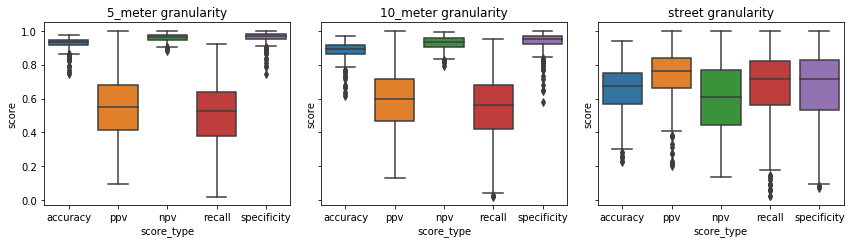

In [11]:
gran_types = ['5_meter', '10_meter', 'street']
fig, ax = plt.subplots(ncols=3, sharey=True)
for i, gran in enumerate(gran_types):
    labels = data[data.granularity == gran][label_cols] # labels with given granularity
    s = labels.stack().reset_index() # condense all score types to one column
    s.columns = ['index', 'score_type', 'score']
    
    b = sns.boxplot(x=s['score_type'], y=s['score'], ax=ax[i])
    b.set_title(gran + ' granularity')   
fig.set_size_inches(12, 3.5)
fig.tight_layout()

Except for precision (ppv) and recall, the scores are much higher and with less variation for 5 and 10 meter granularity. In order to understand why, we can look at the raw counts of true positives, false posivies, etc.

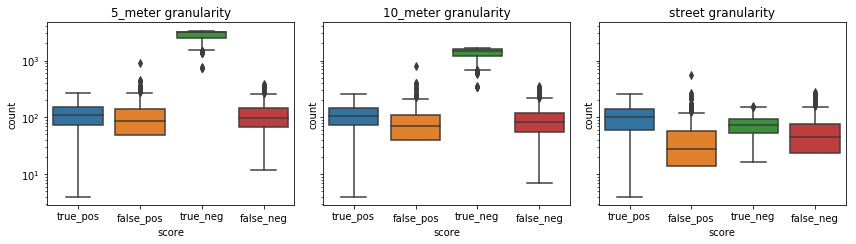

In [12]:
raw_score_cols = ['true_pos', 'false_pos', 'true_neg', 'false_neg']
fig, ax = plt.subplots(ncols=3, sharey=True)
for i, gran in enumerate(gran_types):
    labels = data[data.granularity == gran][raw_score_cols] # tp,fp,tn,fn for given granularity
    s = labels.stack().reset_index() # move all score types to one column
    s.columns = ['index', 'score', 'count']
    
    ax[i].set_yscale('log')
    b = sns.boxplot(x=s['score'], y=s['count'], ax=ax[i])
    b.set_title(gran + ' granularity')
    
fig.set_size_inches(12, 3.5)
fig.tight_layout()

5 and 10 meter granularity have an order of magnitude more true negatives than other the other scores. The smaller granularity means that less area is required to be considered a true negative, and thus many more true negatives occur. Precision and recall were not affected much because they do not depend on the number of true negatives. The other three scores were inflated by the disparate number of true negatives. To avoid this effect, we will use street level granularity to judge users.

#### Label correlation
To further understand our labels for the data, we can look at the relationship between the different scores.

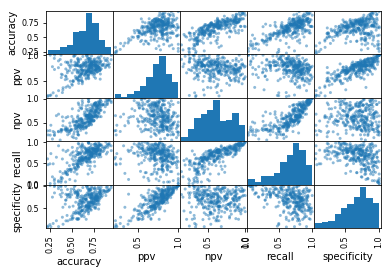

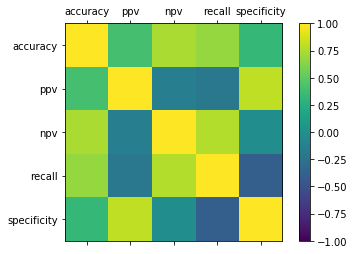

In [13]:
# draw correlation scatterplots
labels = data[data.granularity == 'street'][label_cols]
scatter_matrix(labels, diagonal='hist')

# draw correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(labels.corr(), vmin=-1, vmax=1)
ax.set_xticklabels([''] + label_cols)
ax.set_yticklabels([''] + label_cols)
fig.colorbar(cax)
plt.show()

Scores like precision (ppv) and recall are inversely correlated. Accuracy has a positive correlation with every score. It also takes data into account, so we will use it as the main judge of user performance.

#### Principal Component Analysis
Now that we have looked at the features and lables, we can look for patterns between them. Principal component analysis combines features to reduce dimensionality of the data with a minimal loss of information.

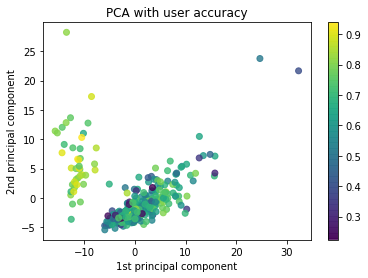

In [14]:
# Create a regular PCA model 
pca = decomposition.PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(features)

x = reduced_data_pca[:,0]
y = reduced_data_pca[:,1]
cax = plt.scatter(x=x, y=y, c=labels.accuracy, alpha=0.8)
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.title("PCA with user accuracy")
plt.colorbar(cax)
plt.show()

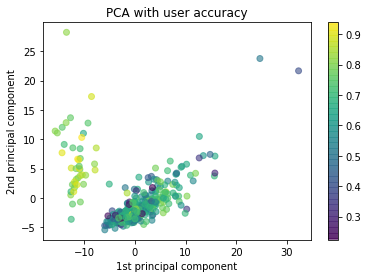

In [15]:
# Create a regular PCA model 
pca = decomposition.PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(features)

plt.scatter(x=reduced_data_pca[:,0], y=reduced_data_pca[:,1], c=labels.accuracy, alpha=0.6)
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.colorbar()
plt.title("PCA with user accuracy")
plt.show()

In the 2-component PCA scatter, we see two clusters. The left cluster is smaller and is composed of a subset of all high-performing users. In the center, the cluster contains a majority of users and is mixed between high and low-performing users. This is an indication that low-performing will be difficult to isolate from others.

#### SVM
##### Regression
To model this data, we can use supervised machine learning. One popular class of algorithm is support vector machine (SVM). For classification, SVM selects hyperplanes that minimize error by maximizing the margin between classes of data. For regression, it works similarilty: a hyper plane is fit along the data. If the data is not linear, a kernel function is used to transform the data. Our user accuracy label is continuous, so we will use regression.

SVM regression has two major hyper parameters: $C$, the penalty for error, and $epsilon$, the margin of tolerance for errors. In order to choose values for the hyper parameters, we can test out a range of options. Here, we use the scikit-learn SVM regression implementation with a radial-basis kernel, $epsilon$ of $0.1$, and a range of $C$ values from $0.01$ to $1.0$. The tests are done with 3-fold cross validation.

Max C: 0.191836734694


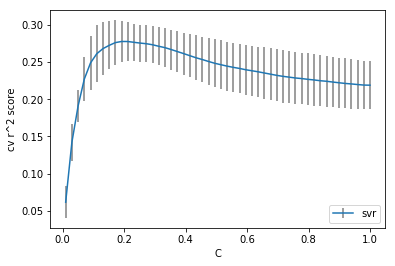

In [16]:
c_values = np.linspace(0.01, 1, 50)
svr = svm.SVR(epsilon=0.1)
svr_scores = []
svr_err = []
for c in c_values:
    svr.set_params(C=c)
    cv = model_selection.cross_val_score(svr, features, labels.accuracy, cv=3)
    svr_scores.append(np.mean(cv))
    svr_err.append(np.std(cv))
print('Max C:', c_values[np.argmax(svr_scores)])
plt.xlabel('C')
plt.ylabel('cv r^2 score')
plt.errorbar(c_values, svr_scores, label='svr', yerr=svr_err, ecolor='grey')
plt.legend(loc='lower right')
plt.show()

The regressor had the best performance around $C=0.2$ We can rerun a similar test on possible $epsilon$ values.

Max epsilon: 0.0510293877551


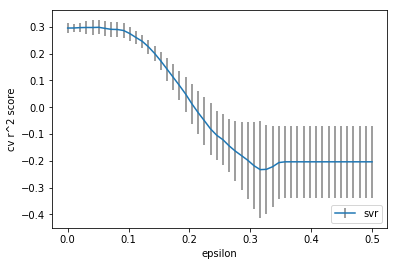

In [17]:
epsilon_values = np.linspace(0.00001, 0.5, 50)
svr = svm.SVR(C=0.2)
svr_scores = []
svr_err = []
for epsilon in epsilon_values:
    svr.set_params(epsilon=epsilon)
    cv = model_selection.cross_val_score(svr, features, labels.accuracy, cv=3)
    svr_scores.append(np.mean(cv))
    svr_err.append(np.std(cv))
print('Max epsilon:', epsilon_values[np.argmax(svr_scores)])
plt.xlabel('epsilon')
plt.ylabel('cv r^2 score')
plt.errorbar(epsilon_values, svr_scores, label='svr', yerr=svr_err, ecolor='grey')
plt.legend(loc='lower right')
plt.show()

The regessor had the best performance around $epsilon = 0.05$. We've seen how the parameters impact the model individualy, but not how they interact together. In order to optimize the model with both of them, we can use a grid search to test out each combination of parameters. In addition to the radial-basis function, we also test a polynomial kernel. We also increase the cross validation to 10-fold.

r^2: 0.30 (+/- 0.19)


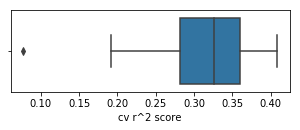

In [18]:
parameters ={
    'C': np.power(10.0,range(-2,3)), 'epsilon': np.power(10.0,range(-4,-1)), 'kernel': ('poly', 'rbf')}
svr = svm.SVR()
clf = model_selection.GridSearchCV(svr, parameters, n_jobs=-1)
scores = model_selection.cross_val_score(clf, features, labels.accuracy, cv=10)
fig = plt.figure()
sns.boxplot(x=scores)
plt.xlabel('cv r^2 score')
fig.set_size_inches(5,1.5)
print("r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We received an $r^2$ score of 0.3 with a 95% confidence interval between 0.1 and 0.5. The $r^2$ score is an indication of how well the actual test data fitted the regression. A score of 1.0 would indicate a perfect fit. Our score indicates that the majority of the variation in accuracy is not explained by the model.

##### Classification

Because the SVM is struggling to predict accuracy as a continuous variable, we can ease its task. Using binning, we can discretize accuracy into categories. Here, we halve our data into two categories: users below median accuracy, and users above. To predict which group a user belongs to, we can use an SVM classifier. Here, we score the classifier's predictions using gridsearch on $C$ and kernel type with 10-fold cross validation.

cv: 0.68 (+/- 0.17)


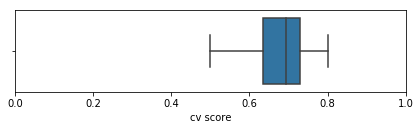

In [19]:
parameters = {'C': np.power(10.0,range(-2,3)), 'kernel': ('poly', 'rbf')}
binned_accuracy = (labels.accuracy < labels.accuracy.median()).apply(lambda x: 1 if x else 0)
svc = svm.SVC()
clf = model_selection.GridSearchCV(svc, parameters, n_jobs=-1)
scores = model_selection.cross_val_score(clf, features, binned_accuracy, cv=10)
fig = plt.figure()
sns.boxplot(x=scores)
plt.xlim(0,1)
fig.set_size_inches(7,1.5)
plt.xlabel('cv score')
print("cv: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

On the binned data, the SVM correctly classifies about 70% of the users. Since the data is evenly distributed between binary categories, a random classification would result in 50% being correct. To understand where the classifier makes mistakes, we can view the confusion matrix.

In [20]:
f_train, f_test, a_train, a_test = model_selection.train_test_split(features, binned_accuracy, test_size=0.5)
clf.fit(f_train, a_train)
metrics.confusion_matrix(a_test, clf.predict(f_test))

array([[54, 22],
       [19, 59]])

As shown in the confusion matrix, the number of false positives and false negatives are approximately equal, as are the number of true positives and true negatives. By altering parameters of the model, we lean it more towards one of these error types. The receiver operating characteristic shows us the trade off between selecting all low-performing users users (0 false negative) and avoiding the selection of high-performing users by mistake (0 false positive).

area under curve: 0.803652968037


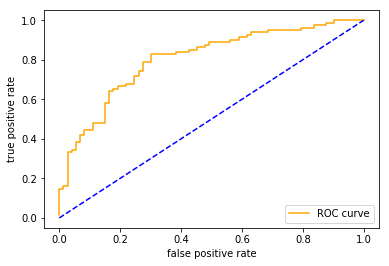

In [21]:
f_train, f_test, a_train, a_test = model_selection.train_test_split(features, binned_accuracy, test_size=0.5)
a_score = svm.SVC().fit(f_train, a_train).decision_function(f_test)
fpr, tpr, _ = metrics.roc_curve(a_test, a_score)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr, color='orange', label='ROC curve')
plt.plot([0,1],[0,1], color='b', linestyle='--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
print('area under curve:', roc_auc)

A perfect model would reach the top left corner of the graph and have 100% area under curve. Our model has around 80% area under curve.

##### Feature coefficients
SVM also allows us to look at the weights it gave to each feature, which makes the prediction more transparent.

In [22]:
clf = svm.SVC(kernel='linear')
clf.fit(features, binned_accuracy)
coef = clf.coef_.ravel()
top_pos = np.argsort(coef)[::-1]
print('Top features leading to classification as poor performing:')
for i, pos in enumerate(top_pos[:5]):
    print(i+1, feature_cols[pos], coef[pos])
print('\nTop features leading to classification as high performing:')
for i, pos in enumerate(top_pos[-5:][::-1]):
    print(i+1, feature_cols[pos], coef[pos])

Top features leading to classification as poor performing:
1 LowLevelEvent_keydown_per_pan_std 1.12946853427
2 PanoId_Changed_per_pan_std 0.931386498261
3 ContextMenu_RadioChange_per_pan_std 0.929422110731
4 PopUpShow_CheckBothSides_per_pan_mean 0.91432620227
5 Click_ModeSwitch_NoCurbRamp_total 0.829416588987

Top features leading to classification as high performing:
1 TaskEnd_total -1.17914680012
2 PanoId_Changed_per_pan_mean -1.15446703378
3 ModeSwitch_CurbRamp_per_pan_mean -0.921973779003
4 ModeSwitch_Walk_per_pan_mean -0.918854969043
5 TaskEnd_per_pan_mean -0.912891970308
